In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle

from collections import Counter
from utils import ReachFinder

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

In [3]:
G = nx.read_gexf("../../PyPi Network V3.gexf")
print(G)

DiGraph with 168382 nodes and 783493 edges


## Alcance de los nodos

In [4]:
def get_reach(G: nx.Graph, p: float = 1) -> pd.DataFrame:
    """
    Get reach of each node for a given probability 'p'.

    Args:
        G (nx.Graph): Networkx Graph.
        p (float, optional): Probability 'p'. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with reach of each node.
    """

    search = ReachFinder(G, p = p)

    # Find reach of each node.
    reach_by_node = search.find_all_nodes()
    reach_by_node = search.remove_self_edges(reach_by_node)

    # Sort libs by reach descending.
    reach_amount = dict(sorted([(k, len(v)) for k, v in reach_by_node.items()], key = lambda x: x[1], reverse=True))
    reach_df = pd.DataFrame([(k, v) for k, v in reach_amount.items()], columns = ["Library", "Reach"]).set_index("Library")

    return reach_df

reach_by_node = get_reach(G, p = 1)

Done. Function called 168382 times.


## K-Coreness

In [5]:
def delete_by_degree(G: nx.Graph, k = 0):
    G_copy = G.copy()
    
    node_degree = dict(sorted(G.out_degree(), key=lambda x: x[1]))
    k_nodes = [n for n in G_copy.nodes() if node_degree[n] == k]

    if len(k_nodes) != 0:
        G_copy.remove_nodes_from(k_nodes)
    else:
        G_copy = delete_by_degree(G = G_copy, k = k+1)
    return G_copy

def k_coreness(G):
    coreness = {node: 0 for node in G.nodes()}
    G_copy = G.copy()

    i = 1
    
    while G_copy.nodes():

        G_copy = delete_by_degree(G_copy, k = 0)

        prevalent_nodes = G_copy.nodes()
        for node in prevalent_nodes:
            coreness[node] += 1

        i += 1
    
    return coreness

coreness = k_coreness(G)
coreness = dict(sorted(list(coreness.items()), key = lambda x: x[1], reverse=True))

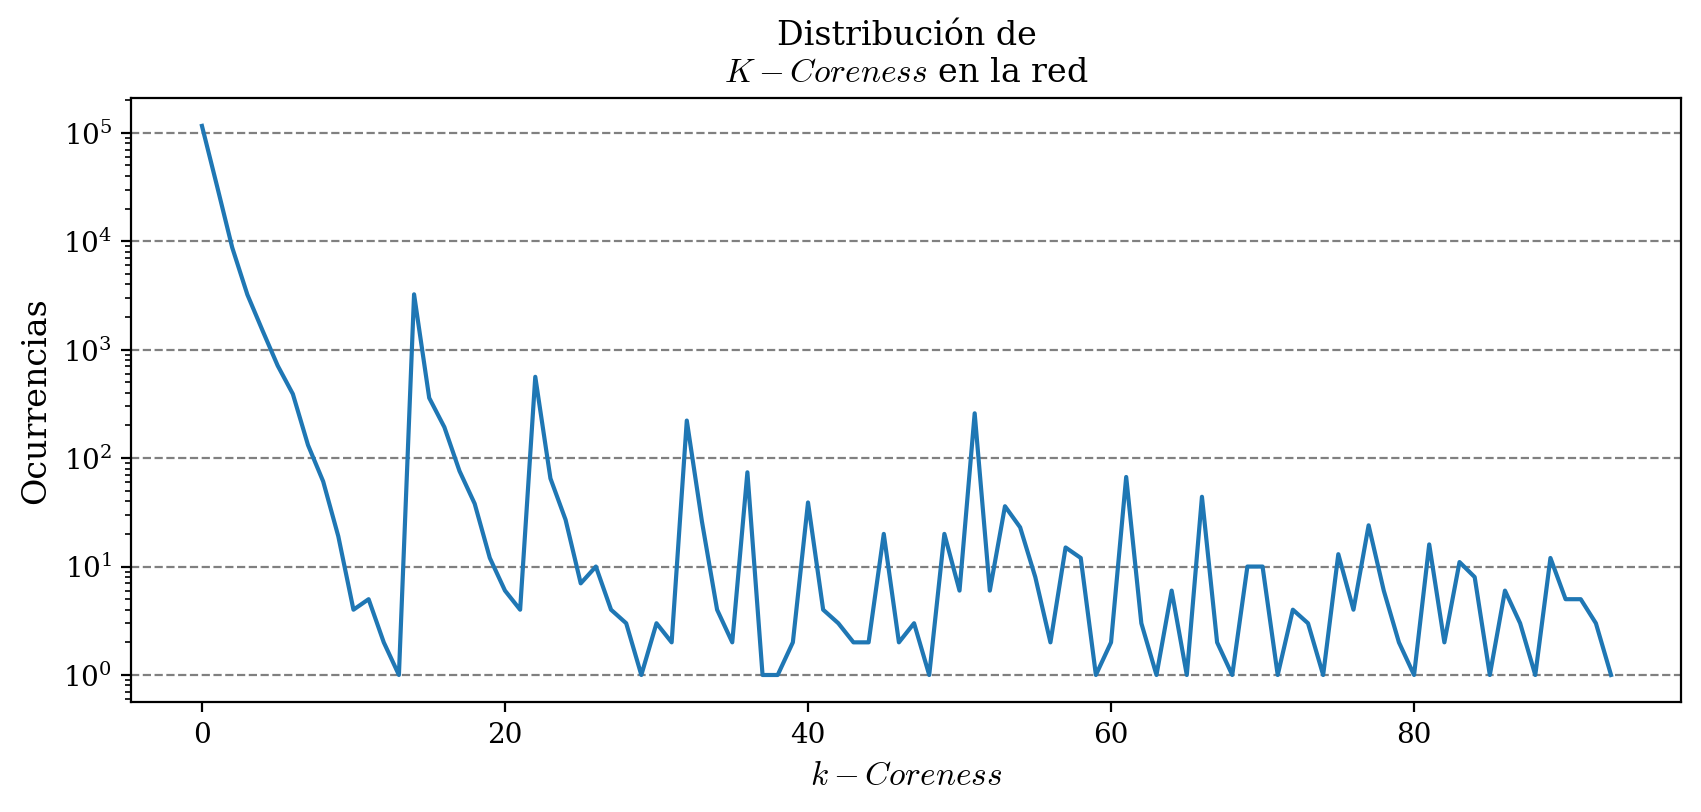

In [6]:
count_coreness = Counter(coreness.values())
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

#ax.hist(coreness.values(), bins = 100)
ax.plot(count_coreness.keys(), count_coreness.values())
ax.set_yscale("log")
ax.set_xlabel("$k-Coreness$")
ax.set_ylabel("Ocurrencias")
ax.set_title("Distribución de\n$K-Coreness$ en la red")
ax.grid(color="gray", ls="--", axis = "y")
plt.show()

## Gráficos

In [7]:
comp = sorted(list(nx.connected_components(nx.Graph(G))), key = len, reverse=True)
comp_len = [len(c) for c in comp]
comp_len_counts = dict(Counter(comp_len))

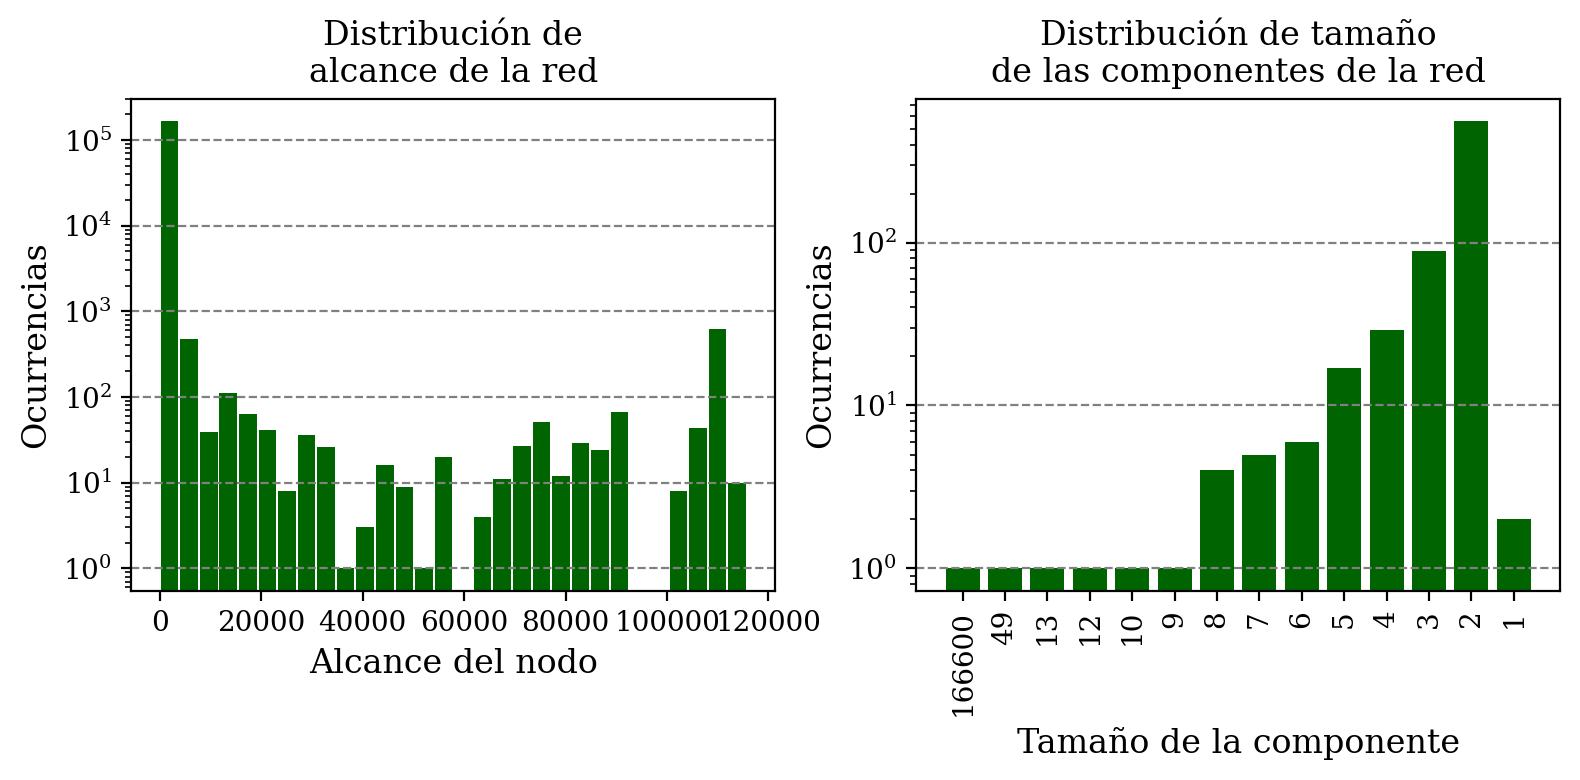

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# Histograma de alcance de los nodos.
ax[0].hist(reach_by_node["Reach"], bins = 30, rwidth=0.90, color="darkgreen")
ax[0].set_yscale("log")
ax[0].grid(color="gray", ls="--", axis="y")
ax[0].set_xlabel("Alcance del nodo")
ax[0].set_ylabel("Ocurrencias")
ax[0].set_title("Distribución de\nalcance de la red")

# Distribución de componentes en la red.
ax[1].bar(range(len(comp_len_counts)), comp_len_counts.values(), color="darkgreen")
ax[1].set_xticks(range(len(comp_len_counts)))
ax[1].set_xticklabels(comp_len_counts.keys(), rotation = 90)
ax[1].set_yscale("log")
ax[1].grid(color="gray", ls="--", axis="y")
ax[1].set_xlabel("Tamaño de la componente")
ax[1].set_ylabel("Ocurrencias")
ax[1].set_title("Distribución de tamaño\nde las componentes de la red")

plt.show()

- La componente 1 es...
- La componente 2 son todos los paquetes de https://github.com/musculoskeletal/gias3.

## Librerias con mayor alcance.

Elegimos estas porque después hay un salto significativo en el alcance.

In [9]:
top_reach_libs = list(reach_by_node["Reach"].head(679).index)

with open("../../PyPi filtered DataFrame.df", "rb") as f:
    df = pickle.load(f)

df.head(5)

,Dependencies,Tags,Licence,Package Version,Python Version,Classifiers,Dependant Libraries Count,Programming Language
0-core-client,[redis],None,Apache 2.0,1.1.0a8,None,[],0.0,None
0-orchestrator,"[jinja2, aioredis, etcd3, netaddr, python-date...",None,Apache 2.0,1.1.0a8,None,[],0.0,None
01d61084-d29e-11e9-96d1-7c5cf84ffe8e,"[click, attrs]",None,None,0.1.0,">=3.7,<4.0","[Programming Language :: Python :: 3, Programm...",2.0,Python
0x-contract-addresses,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",6.0,Python
0x-contract-artifacts,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",4.0,Python


## Ajuste (Enfoque probabilistico desechado)

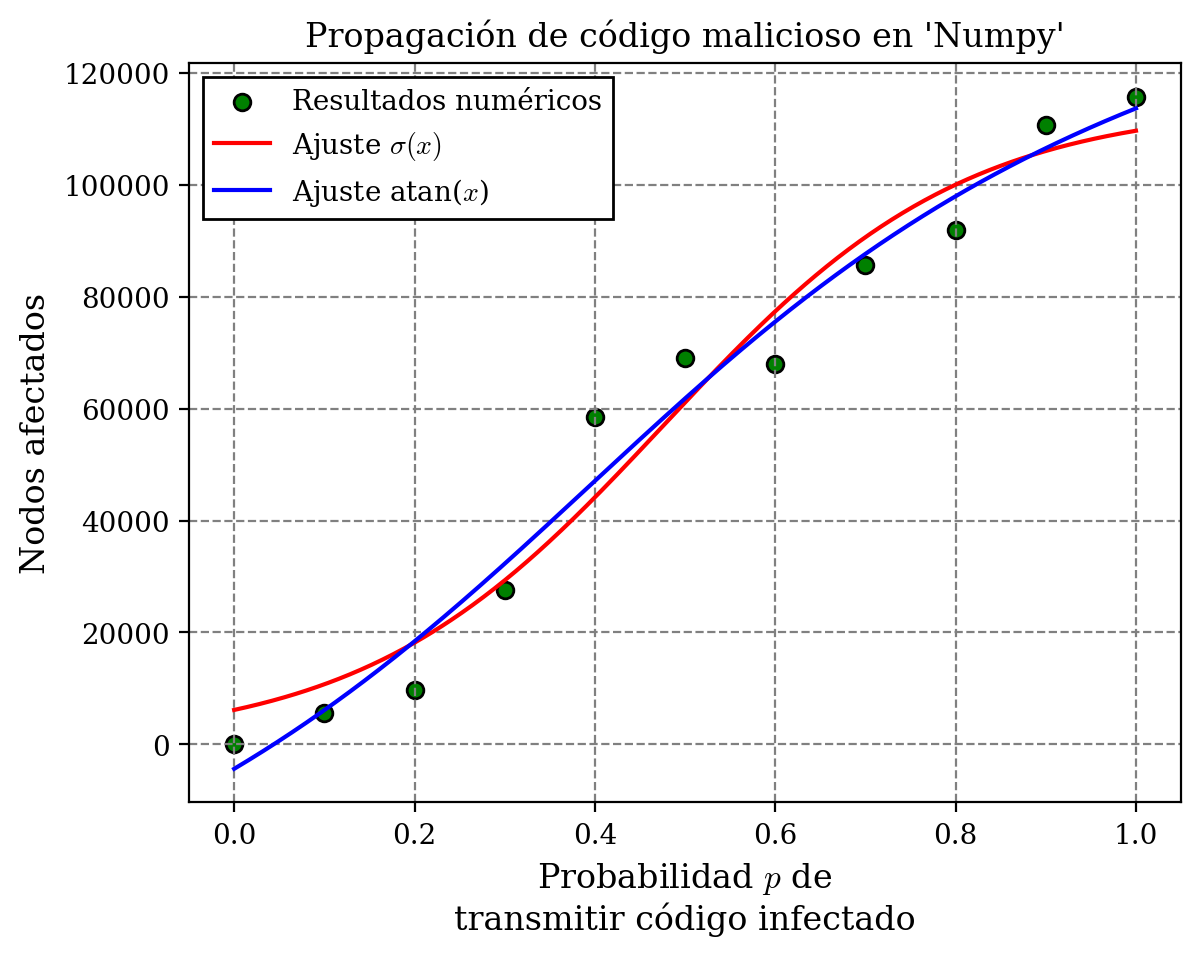

In [40]:
from scipy.optimize import curve_fit

sigmoid = lambda x, a, b, c: a/(1 + np.exp(-b*x - c))
arctan = lambda x, a, b, c, d: a*np.arctan(b*x + c) + d

popt, pcov = curve_fit(sigmoid, probs, np_probs, p0 = [120000, 1, 0.5])
popt2, pcov2 = curve_fit(arctan, probs, np_probs)
p = np.linspace(0, 1, 500)

plt.scatter(probs, np_probs, ec="black", label="Resultados numéricos", color="green")
plt.plot(p, sigmoid(p, *popt), label="Ajuste $\sigma(x)$", color="red")
plt.plot(p, arctan(p, *popt2), label="Ajuste atan($x$)", color="blue")
plt.legend(loc="upper left", fancybox=False, edgecolor="black", framealpha=1)

plt.xlabel(f"Probabilidad $p$ de\ntransmitir código infectado")
plt.ylabel(f"Nodos afectados")
plt.title("Propagación de código malicioso en 'Numpy'")
plt.grid(color="gray", ls="--")